# Control Flow Graph

##  Install required packages.

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 62.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.1 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-x7xvhmwp
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-x7xvhmwp
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 4410298df8de8ca9f13ba4ee12e6a30ec82c42d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=1234816 sha256=99f67f7aea23492e2da343285df09c3fe9a7fb91a20592c4220dbf713a3bb4b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-j8pgs

In [3]:
!unzip "data.zip" -d '.'

Streaming output truncated to the last 5000 lines.
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2024-5-2-NovaMind/._@openzeppelin  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/._0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/._0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/0x9bc699780A326C059C660C6ee2EF1D8583D01aEa.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/._0x9bc699780A326C059C660C

In [2]:
!unzip "utils.zip" -d '.'

Archive:  utils.zip
   creating: ./utils/
   creating: ./utils/__pycache__/
  inflating: ./__MACOSX/utils/.___pycache__  
  inflating: ./utils/threshold.py    
  inflating: ./utils/comparing.py    
  inflating: ./utils/__pycache__/comparing.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._comparing.cpython-312.pyc  
  inflating: ./utils/__pycache__/threshold.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._threshold.cpython-312.pyc  


##  Set up

In [4]:
import os
import pandas as pd
import pickle
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import from_networkx

from sklearn.model_selection import train_test_split
from utils.threshold import tune_thresholds
from utils.comparing import evaluate_multilabel_classification

PATH = './data/labeled'

In [5]:
# Load features (ensure index is lowercase)
def load_feature(file):
    df = pd.read_csv(file, index_col=0)
    df.index = df.index.str.lower()
    return df

In [6]:
# Load ground truth
ground = pd.read_csv(os.path.join(PATH, "groundtruth.csv")).set_index('Address')
ground.index = ground.index.str.lower()
label_cols = [col for col in ground.columns]
graph = load_feature(os.path.join(PATH,"cfg_graph_features.csv"))

with open(os.path.join(PATH, "cfg.pkl"), "rb") as f:
    graphs = pickle.load(f)

In [7]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden*2)
        self.conv2 = GCNConv(hidden*2, hidden)
        self.lin = nn.Linear(hidden, out_channels)
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

## Load Data

In [8]:
dataset = []

for i, (address, graph_data) in enumerate(graphs.items()):
    # Check if the address exists in the ground truth DataFrame
    if address in ground.index:
        feature = graph.loc[address].values.reshape(1, -1) # Use cfg_graph features for cfg_dataset
        data = from_networkx(graph_data)
        data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
        data.y = torch.tensor(ground.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension
        if i < 10:
            print(data)
        dataset.append(data)

Data(edge_index=[2, 118], num_nodes=155, x=[155, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=194, x=[194, 6], y=[1, 3])
Data(edge_index=[2, 178], num_nodes=339, x=[339, 6], y=[1, 3])
Data(edge_index=[2, 78], num_nodes=113, x=[113, 6], y=[1, 3])
Data(edge_index=[2, 211], num_nodes=303, x=[303, 6], y=[1, 3])
Data(edge_index=[2, 158], num_nodes=377, x=[377, 6], y=[1, 3])
Data(edge_index=[2, 365], num_nodes=683, x=[683, 6], y=[1, 3])
Data(edge_index=[2, 137], num_nodes=215, x=[215, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=192, x=[192, 6], y=[1, 3])
Data(edge_index=[2, 4], num_nodes=584, x=[584, 6], y=[1, 3])


## Labels Distibution

In [9]:
label_distribution = torch.zeros(len(label_cols))

for data in dataset:
    label_distribution += data.y.squeeze(0)  # Remove batch dimension

from collections import Counter

combo_counter = Counter()

for data in dataset:
    labels = tuple(data.y.squeeze(0).int().tolist())
    combo_counter[labels] += 1

# Display counts for each label combination
for combo, count in combo_counter.items():
    print(f"{combo}: {count}")


(0, 0, 0): 27
(0, 0, 1): 14
(1, 1, 1): 1
(0, 1, 0): 3
(1, 0, 1): 9
(0, 1, 1): 4
(1, 0, 0): 8
(1, 1, 0): 1


/tmp/ipython-input-10-3678270687.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x="Label", y="Count", palette="Set2")


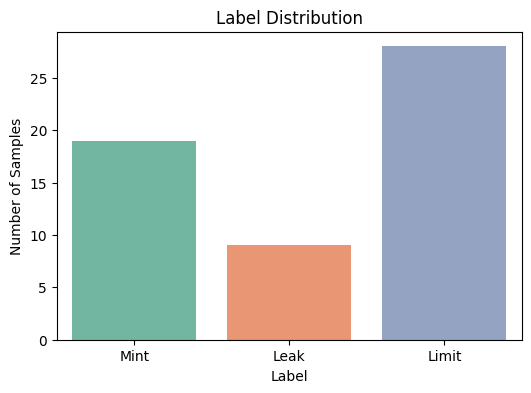

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract label counts
label_counts = {label: int(label_distribution[i].item()) for i, label in enumerate(label_cols)}
df_counts = pd.DataFrame(list(label_counts.items()), columns=["Label", "Count"])

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df_counts, x="Label", y="Count", palette="Set2")
plt.title("Label Distribution")
plt.ylabel("Number of Samples")
plt.show()


/tmp/ipython-input-11-323338011.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[str(key) for key in combo_counter.keys()], y=combo_counter.values(), palette="Set2")


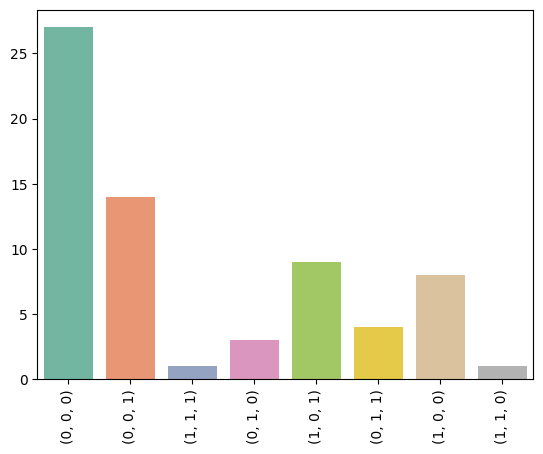

In [11]:
sns.barplot(x=[str(key) for key in combo_counter.keys()], y=combo_counter.values(), palette="Set2")
plt.xticks(rotation=90)
plt.show()

## Split Train and Test

In [12]:
from torch_geometric.loader import DataLoader

# Split your dataset
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=15, shuffle=False)

In [13]:
model = GCN(in_channels=graph.shape[1], hidden=64, out_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()  # For multi-label classification

## Train

In [14]:
for epoch in range(1, 51):  # max 50 epochs
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = (torch.sigmoid(out) > 0.5).int().cpu().numpy()
        labels = batch.y.int().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    acc = (all_preds == all_labels).mean()

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


Epoch 1, Loss: 21.8487, Accuracy: 0.3774
Epoch 2, Loss: 11.1141, Accuracy: 0.6792
Epoch 3, Loss: 11.0198, Accuracy: 0.7358
Epoch 4, Loss: 8.6725, Accuracy: 0.7358
Epoch 5, Loss: 3.6469, Accuracy: 0.6541
Epoch 6, Loss: 5.3464, Accuracy: 0.3962
Epoch 7, Loss: 2.8427, Accuracy: 0.7044
Epoch 8, Loss: 3.0808, Accuracy: 0.7421
Epoch 9, Loss: 3.5652, Accuracy: 0.7421
Epoch 10, Loss: 3.0562, Accuracy: 0.6604
Epoch 11, Loss: 3.1098, Accuracy: 0.6164
Epoch 12, Loss: 2.6111, Accuracy: 0.7925
Epoch 13, Loss: 2.8317, Accuracy: 0.7673
Epoch 14, Loss: 2.7005, Accuracy: 0.7673
Epoch 15, Loss: 3.4723, Accuracy: 0.6101
Epoch 16, Loss: 2.4283, Accuracy: 0.7547
Epoch 17, Loss: 3.1321, Accuracy: 0.7358
Epoch 18, Loss: 3.1600, Accuracy: 0.7484
Epoch 19, Loss: 2.4225, Accuracy: 0.7610
Epoch 20, Loss: 2.3479, Accuracy: 0.7044
Epoch 21, Loss: 2.3279, Accuracy: 0.7987
Epoch 22, Loss: 2.2005, Accuracy: 0.7736
Epoch 23, Loss: 2.3119, Accuracy: 0.7484
Epoch 24, Loss: 3.0726, Accuracy: 0.7421
Epoch 25, Loss: 2.8105

## Test

In [15]:
model.eval()
y_true, y_probs = [], []
with torch.no_grad():
    for batch in test_loader:
        out = torch.sigmoid(model(batch))
        y_probs.append(out.cpu())
        y_true.append(batch.y.cpu())

y_true = np.vstack(y_true)
y_probs = np.vstack(y_probs)

best_thresholds, _ = tune_thresholds(y_true, y_probs)

Label 0: Best threshold = 0.31, Best f1 = 0.6667
Label 1: Best threshold = 0.01, Best f1 = 0.4706
Label 2: Best threshold = 0.00, Best f1 = 0.6667


In [16]:
evaluate_multilabel_classification(y_true, y_probs, label_names=label_cols, threshold=best_thresholds)

({'micro_precision': 0.43333333333333335,
  'micro_recall': 0.9285714285714286,
  'micro_f1': 0.5909090909090909,
  'macro_precision': 0.4914529914529915,
  'macro_recall': 0.8888888888888888,
  'macro_f1': 0.6013071895424836,
  'weighted_precision': 0.4807692307692308,
  'weighted_recall': 0.9285714285714286,
  'weighted_f1': 0.6106442577030812,
  'subset_accuracy': 0.21428571428571427},
               precision    recall  f1-score  support
 Mint           0.666667  0.666667  0.666667      3.0
 Leak           0.307692  1.000000  0.470588      4.0
 Limit          0.500000  1.000000  0.666667      7.0
 micro avg      0.433333  0.928571  0.590909     14.0
 macro avg      0.491453  0.888889  0.601307     14.0
 weighted avg   0.480769  0.928571  0.610644     14.0
 samples avg    0.440476  0.607143  0.497619     14.0)